## Sampling a Data Stream

Say we are interested in understanding the distribution (counts) of emojis in a (potentially unlimited) stream of tweets. However, remember that one of the biggest challenges in mining data streams is that **we have limited storage capacity for the very high volume of incoming data, which may arrive at a very high velocity as well**. So for hyppothetical purposes, **we cannot store or process all tweets at once, but are constrained to deal with only one or a few tweets at a time**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import json
from emoji import UNICODE_EMOJI
import os
from pathlib import Path
from collections import defaultdict
from random import Random
import numpy as np
from collections import Counter

print('done')

done


In [2]:
# navigate github folders for asset library
#p=Path(os.getcwd())
#os.chdir(p.parent)
#os.getcwd()

In [3]:
def extract_emojis(text):
    """
    Extract all emojis from a str
    """
    return [ch for ch in text if ch in UNICODE_EMOJI]

class TwitterStream:
    """
    Used to simulate a Twitter stream. 
    """
    
    def __init__(self, data_file):
        self.data_file = data_file
        self.data = open(self.data_file, "r")
    
    def __iter__(self):
        return self.reset()
    
    def __next__(self):
        next_line = self.data.readline()
        if next_line:
            return json.loads(next_line)["text"]
        else:
            raise StopIteration
    
    def __del__(self):
        if not self.data.closed:
            self.data.close()
    
    def reset(self):
        if not self.data.closed:
            self.data.close()
        self.data = open(self.data_file, "r")
        return self

In [4]:
twitter_stream = TwitterStream("assets/tweets")  # instantiate a Twitter stream from a data file

# use a for-loop to iterate through the stream, just like iterating over a list
for index, tweet in enumerate(twitter_stream):
    print(index, tweet)
    if index >= 3:  # only prints the first 4 tweets
        break

twitter_stream.reset() # reset the stream so that it begins with the first tweet
print()

# OR
# use a while-loop together with the "next" function to retrieve one tweet from the stream at a time
index = 0
while index < 4: 
    print(index, next(twitter_stream)) # the built-in "next" function retrieves the next item in an iterator
    index += 1

del twitter_stream, index

0 Recently arrived in Australia - just been out on my evening dog walk and decided to give @petercrouch podcast a listen - wow...what have I been missing - absolutely hilarious! #thatpetercrouchpodcast
1 Lmaoooooo love you allll
2 Good morning! kita mo nga naman isang panibagong araw para maging malungkot ulit🤧
3 Here we go ⚓️

0 Recently arrived in Australia - just been out on my evening dog walk and decided to give @petercrouch podcast a listen - wow...what have I been missing - absolutely hilarious! #thatpetercrouchpodcast
1 Lmaoooooo love you allll
2 Good morning! kita mo nga naman isang panibagong araw para maging malungkot ulit🤧
3 Here we go ⚓️


Many sampling algorithms require "tossing a coin", that is, a psudo-random generator (PRG). To make our lives easier in this notebook we are going to create a special "history-preserving" PRG.

In [5]:
class HistPresvRandom:
    """
    History-preserving Random Number Generator
    """
    
    def __init__(self, seed=None):
        self.prg = Random(seed)
        self.hist = defaultdict(list)
    
    def random(self): # works exactly like random.random()
        num = self.prg.random()
        self.hist["random"].append(num)
        return num
    
    def sample(self, population): # works exactly like random.sample(population, 1)[0]
        num = self.prg.sample(population, 1)[0]
        self.hist["sample"].append(num)
        return num

hist_presv_random = HistPresvRandom(0)
print(f'"random" method: {hist_presv_random.random()}')
print(f'"sample" method: {hist_presv_random.sample(range(10))}')

del hist_presv_random

"random" method: 0.8444218515250481
"sample" method: 6


In [6]:
# Random Sampling
class RandomSampler:
    
    def __init__(self, in_sample_prob, seed=None):
        
        self.in_sample_prob = in_sample_prob
        self.random = HistPresvRandom(seed) # used whenever randomness is needed in your solution
        self.sample, self.counts = list(), defaultdict(int) # recommended to use defaultdict, but an ordinary dict works fine too
    
    def _process_new_item(self, item):
        """
        Applies random sampling to a newly arrived item
        """
        if self.random.random() < in_sample_prob:
            
            # append 
            self.sample.append(item)
            
            
            # extract emojis
            # add to counts    
            for e in extract_emojis(item):
                self.counts[e] += 1
                  

    
    def do_sampling(self, stream):
        """
        Iterates over a stream and performs random sampling
        """
        
        self.sample.clear() # clear the existing sample
        self.counts.clear() # clear the existing counts
        
        for item in stream: # iterate over the stream
            
            # perform random sampling
            self._process_new_item(item)
            
            # returns a copy of sample and counts at the end of every iteration for grading - code given
            yield self.sample.copy(), self.counts.copy()

In [7]:
in_sample_prob, seed = 0.1, 42
rand_sam = RandomSampler(in_sample_prob, seed)

# Do sampling. Don't have to collect the results. Just exhaust the stream
for _ in rand_sam.do_sampling(TwitterStream("assets/tweets")):
    pass

sorted_counts = {emoji: rand_sam.counts[emoji] for emoji in sorted(rand_sam.counts.keys(), key=rand_sam.counts.get, reverse=True)}
print(sorted_counts)

{'😂': 194, '😭': 69, '❤': 57, '🤣': 51, '✨': 50, '🏻': 40, '🔥': 37, '🥺': 35, '🙏': 32, '👏': 32, '😍': 30, '👍': 29, '♥': 23, '💕': 21, '🇸': 20, '♀': 20, '😅': 20, '☺': 18, '🥰': 17, '🇦': 16, '😎': 16, '🏽': 16, '💜': 16, '💚': 15, '🏾': 15, '😊': 14, '😆': 14, '😢': 14, '🍍': 14, '💪': 13, '😳': 13, '😩': 12, '‼': 12, '♂': 12, '🤭': 12, '💙': 11, '👇': 11, '💖': 10, '😱': 10, '💛': 10, '😹': 10, '🤔': 9, '🖤': 9, '🎉': 9, '🚨': 9, '🙄': 9, '♻': 9, '🙌': 8, '💦': 8, '❗': 8, '😷': 8, '🤷': 8, '😈': 8, '💀': 8, '⚡': 8, '😔': 7, '🥵': 7, '😁': 7, '⭕': 7, '🏅': 7, '💗': 7, '🌹': 7, '✌': 7, '⚠': 7, '😘': 6, '🌟': 6, '😌': 6, '🌸': 6, '🗣': 6, '🤪': 6, '😤': 6, '🤦': 6, '❣': 5, '🍑': 5, '💔': 5, '✊': 5, '🤤': 5, '💓': 5, '🦋': 5, '😇': 5, '💎': 5, '🇬': 5, '🇨': 5, '😥': 5, '⚰': 5, '🙂': 5, '👋': 5, '↙': 5, '👉': 5, '🐰': 5, '🐨': 5, '💣': 5, '🥳': 5, '✅': 5, '🐬': 5, '💘': 4, '😉': 4, '😐': 4, '🌺': 4, '💝': 4, '🇪': 4, '▶': 4, '🇧': 4, '👩': 4, '🙃': 4, '😄': 4, '😚': 4, '🤩': 4, '☀': 4, '🏃': 4, '⭐': 4, '▫': 4, '🇳': 4, '🔴': 4, '😙': 3, '🐶': 3, '☝': 3, '🇷': 3, '🥴': 3, '😡': 

## Reservoir Sampling

In [8]:
class ReservoirSampler:
    
    def __init__(self, sample_size, seed=None):
        
        self.sample_size = sample_size
        self.random = HistPresvRandom(seed) # used whenever randomness is needed in your solution
        self.sample, self.counts = list(), defaultdict(int)
    
    def _process_new_item(self, item, index):
        """
        Decides whether a new item should be added to the sample and adjusts the counts accordingly
        """
        
        if self.random.random() < sample_size/(index+1):
            
            # remove jth sample
            j = self.random.sample(range(len(self.sample)))
            del self.sample[j]
            
            # append new
            self.sample.append(item)
            
            # reinitialize dictionary
            self.counts = defaultdict(int)
            
            # add sample counts back to dict
            for s in self.sample:  
                for e in extract_emojis(s):
                    self.counts[e] += 1   
          
    
    def do_sampling(self, stream):
        """
        Iterates over a stream and performs reservoir sampling
        """
        
        self.sample.clear() # clear the existing sample
        self.counts.clear() # clear the existing counts
        
        for index, item in enumerate(stream): # iterate over the stream
            
            # initialize
            if len(self.sample) < sample_size:
                # append 
                self.sample.append(item)
                
                # add to counts    
                for e in extract_emojis(item):
                    self.counts[e] += 1

            else:
                self._process_new_item(item,index) #item, index
                
            
            # returns a copy of sample and counts at the end of every iteration for grading - code given
            yield self.sample.copy(), self.counts.copy()

In [10]:
sample_size, seed = 100, 0
resv = ReservoirSampler(sample_size, seed)

# Do sampling. Don't have to collect the results. Just exhaust the stream
for _ in resv.do_sampling(TwitterStream("assets/tweets")):
    pass

sorted_counts = {emoji: resv.counts[emoji] for emoji in sorted(resv.counts.keys(), key=resv.counts.get, reverse=True)}
print(sorted_counts)

{'😭': 24, '🥰': 18, '❤': 11, '😂': 8, '💙': 8, '🥺': 7, '😍': 7, '🇸': 6, '🇺': 5, '✨': 4, '‼': 4, '♂': 3, '🏆': 3, '😘': 2, '👍': 2, '☺': 2, '❗': 2, '👩': 2, '🙃': 2, '😋': 2, '🔥': 2, '👑': 2, '💕': 2, '♥': 2, '😩': 2, '😏': 1, '🎶': 1, '☀': 1, '🎵': 1, '🐟': 1, '🐰': 1, '👫': 1, '💋': 1, '😈': 1, '💚': 1, '🏀': 1, '🏈': 1, '🎤': 1, '😠': 1, '🌈': 1, '⚽': 1, '✌': 1, '🏼': 1, '😷': 1, '🤦': 1, '🏻': 1, '🤓': 1, '🇦': 1, '🤷': 1, '🏿': 1, '🐳': 1, '💰': 1, '✅': 1, '🥇': 1, '👏': 1, '👉': 1, '\U0001f9be': 1, '😞': 1, '📸': 1, '🤑': 1, '🙏': 1, '🏾': 1, '🙆': 1, '🏽': 1, '🍪': 1, '😇': 1, '😉': 1, '🥴': 1, '🏯': 1, '🦅': 1, '😱': 1, '😓': 1, '👇': 1, '🤗': 1, '💓': 1, '😤': 1, '🐱': 1, '🐥': 1, '🍼': 1, '😪': 1}


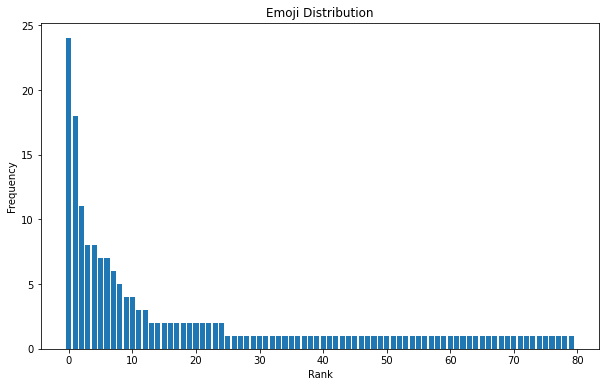

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax

## Counting in a Data Stream

In [12]:
# provides simple and deterministic hash functions
class HashFunction:
    def __init__(self, num_slots):
        self.num_slots = num_slots
        
    def __call__(self, x):
        return (hash(self) + hash(x)) % self.num_slots

Bloom filter doesn't really count items in a data stream but is able to tell
* that an item has *definitely not appeared* in the data stream so far; or


* that an item has *possibly appeared* in the data stream so far.

In [13]:
class BloomFilter:
    
    def __init__(self, num_slots, num_hash_fns):
        
        self.slots = np.zeros(num_slots, dtype=int)
        self.hash_fns = [HashFunction(num_slots) for _ in range(num_hash_fns)] # A list of distinct hash functions
    
    def check_appearance(self, item):
        """
        Returns a bool value indicating whether an item has appeared or not
        """
        # Check if any slots are 0
        appeared = []
        for i, h in enumerate(self.hash_fns):
            if self.slots[self.hash_fns[i](item)] == 0:
                appeared.append(False)
            else:
                appeared.append(True)
        
        has_appeared = np.all(appeared) # check's if all are True
        
        return has_appeared
    
    def do_filtering(self, stream):
        """
        Iterates over a stream, collects items of interest, calculates the fingerprints and records the appearance
        """
        
        self.slots = np.zeros_like(self.slots) # reset the slots
        
        for item in stream: # iterate over the stream
            
            # for each emoji find look up hash
            for ch in extract_emojis(item):
                # for each hash change slot to 1
                for i, h in enumerate(self.hash_fns):  
                    self.slots[self.hash_fns[i](ch)] = 1
            
            # returns a copy of slots at the end of every iteration for grading - code given
            yield self.slots.copy()

In [15]:
twitter_stream = TwitterStream("assets/tweets")
bl_flt = BloomFilter(7919, 5)

# Collect emojis that appeared and that didn't appear
emojis_appeared = set()
for tweet in twitter_stream:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))
emojis_not_appeared = set(UNICODE_EMOJI.keys()) - emojis_appeared

# Do filtering. Don't have to collect the results. Just exhaust the stream
for _ in bl_flt.do_filtering(twitter_stream):
    pass

## Lossy Counter

Let's now implement a lossy counter for emojis. The lossy counter should maintain counts of all emojis seen so far and only update the counts once a "bucket" of tweets arrive. The "update" of counts should include increments due to the emojis contained in the new bucket and decrements because we want to gradually get rid of less recent emojis.

In [16]:
class LossyCounter:
    
    def __init__(self, bucket_size):
        
        self.bucket_size = bucket_size
        self.counts = defaultdict(int) # recommended to use defaultdict, but an ordinary dict works fine too
    
    def do_counting(self, stream):
        """
        Iterates over a stream, counts the items and drops the infrequent ones in a bucket
        """
        
        self.counts.clear() # reset the counts
        num_items_in_bucket = 0 # optional: the current number of items in the "bucket"
        temp_bucket = defaultdict(int)
        item_count = 0
                
        for item in stream: # iterate over the stream
                       
            # temp bucket
            if num_items_in_bucket + 1 < self.bucket_size:

                for ch in extract_emojis(item):
                    temp_bucket[ch] += 1
                    
                # increment count
                num_items_in_bucket += 1
                
            else: 
                

                #print(f"stream size = {item_count}")
                #print(f"num_items_in_bucket = {num_items_in_bucket}")
                #print(temp_bucket)
                
                # add the final sample to the bucket
                for ch in extract_emojis(item):
                    temp_bucket[ch] += 1
                
                # pass the new bucket
                for temp in temp_bucket:
                    self.counts[temp] += temp_bucket[temp]
                    
                # subtract from lossy counter
                for key in self.counts:
                    self.counts[key] = self.counts[key] - 1
                    
                #print(f"before removing bins{self.counts}")
                # remove zero
                self.counts = defaultdict(int, {x:y for x,y in self.counts.items() if y>0})
                
                # reset buckets
                num_items_in_bucket = 0
                temp_bucket = defaultdict(int)
            
            # increment count
            item_count += 1
            
            
            # returns a copy of counts at the end of every iteration for grading - code given
            yield self.counts.copy()
            
        if len(self.counts.keys()) == 0: # extreme case bucket not full
                
            self.counts = temp_bucket
            
            yield self.counts.copy()

In [17]:
bucket_size = 100
lossy = LossyCounter(bucket_size)

# Do counting. Don't have to collect the results. Just exhaust the stream
for _ in lossy.do_counting(TwitterStream("assets/tweets")):
    pass

sorted_counts = {emoji: lossy.counts[emoji] for emoji in sorted(lossy.counts.keys(), key=lossy.counts.get, reverse=True)}
print(sorted_counts)

{'😂': 1304, '😭': 911, '❤': 592, '🤣': 401, '🥺': 318, '✨': 317, '🥰': 236, '🔥': 231, '🏻': 228, '🙏': 207, '😍': 205, '💙': 175, '👏': 106, '♥': 97, '♀': 94, '😊': 77, '👍': 72, '💕': 69, '☺': 53, '‼': 47, '🤔': 44, '♂': 25, '💜': 22, '🏼': 21, '😅': 18, '👇': 16, '💦': 13, '😔': 13, '💔': 12, '🤒': 11, '🙇': 11, '💎': 11, '⭐': 10, '😢': 10, '🤦': 9, '👑': 9, '🌸': 7, '😆': 7, '🏾': 7, '🏷': 7, '🏽': 6, '😘': 6, '🤷': 6, '💀': 5, '🙄': 5, '❗': 5, '💢': 5, '💚': 4, '😋': 4, '🇸': 4, '😹': 4, '🤐': 4, '👥': 4, '💥': 4, '💛': 3, '🐥': 3, '😡': 2, '🎁': 2, '💪': 2, '😠': 2, '🤤': 2, '🚨': 2, '🤪': 2, '📣': 2, '😀': 2, '🍆': 2, '😏': 2, '🤮': 1, '😩': 1, '🤭': 1, '🔘': 1, '🖤': 1, '😃': 1, '👀': 1, '▶': 1, '😷': 1, '😁': 1, '〰': 1}


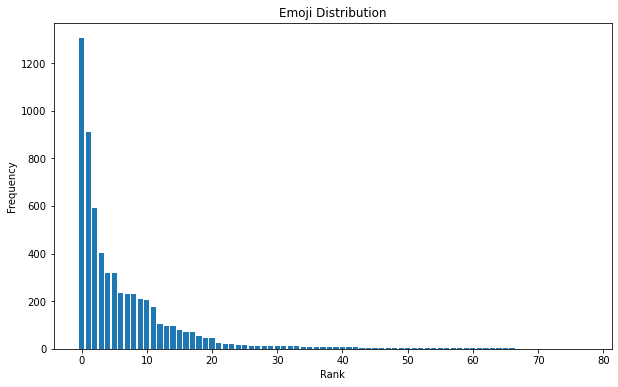

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax